In [1]:
import sys,os,math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
from matplotlib import gridspec as grs
%matplotlib notebook
from matplotlib import cm
from astropy.table import Table
import seaborn as sns
import statsmodels.nonparametric.api as smnp
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.special import expit
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, make_scorer
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
hst_tbl = Table.read("HST_COSMOS_features_adamamiller.fit").to_pandas()
sdss_tbl = Table.read("sdssSP_MLfeats_adamamiller.fit").to_pandas()

In [3]:
len(sdss_tbl)

3834627

In [4]:
len(sdss_tbl[~sdss_tbl.duplicated('objid')])

3834625

In [5]:
sdss_tbl = sdss_tbl[~sdss_tbl.duplicated('objid')]

In [6]:
hst_det = np.where(hst_tbl.nDetections > 0)
hst_kron_mag = np.array(-2.5*np.log10(hst_tbl['wwKronFlux'].loc[hst_det]/3631))

sdss_det = np.where(sdss_tbl.nDetections > 0)
sdss_photo_det = np.logical_and(np.isfinite(sdss_tbl.type),
                                sdss_tbl.countRatio > 0)
sdss_in_common = np.logical_and(np.isfinite(sdss_tbl.iPSFminusKron), 
                                sdss_photo_det)
low_z_gal = np.logical_and(sdss_tbl.z < 1e-4, sdss_tbl['class'] == 'GALAXY')
low_z_qso = np.logical_and(sdss_tbl.z < 1, sdss_tbl['class'] == '   QSO')

sdss_test_set = sdss_in_common & ~low_z_gal & ~low_z_qso

In [7]:
len(sdss_tbl[sdss_test_set])

3592938

In [8]:
features = ['wwpsfChiSq', 'wwExtNSigma', 'wwpsfLikelihood',
            'wwPSFKronRatio', 'wwPSFKronDist',  'wwPSFApRatio',
            'wwmomentRH', 'wwmomentXX', 'wwmomentXY', 'wwmomentYY', 
            'wwKronRad']

In [9]:
hst_ml_train_X = np.array(hst_tbl[features].loc[hst_det])
hst_ml_train_y = np.array(hst_tbl["MU_CLASS"].loc[hst_det] - 1)
sdss_ml_test_X = np.array(sdss_tbl[features].loc[sdss_test_set])
sdss_spec_class = np.array(sdss_tbl['class'].loc[sdss_test_set])
sdss_ml_test_y = np.ones_like(sdss_spec_class).astype(int)
sdss_ml_test_y[np.where(sdss_spec_class == "GALAXY")] = 0

In [10]:
import star_galaxy_models

In [11]:
rf_obj = star_galaxy_models.RandomForestModel()
rf_obj.read_rf_from_pickle()

In [12]:
ML_predict = rf_obj.rf_clf_.predict_proba(sdss_ml_test_X)

In [13]:
ML_fpr, ML_tpr, ML_thre = roc_curve(sdss_ml_test_y, ML_predict[:,1])
sdss_fpr, sdss_tpr,sdss_thre = roc_curve(sdss_ml_test_y, sdss_tbl["countRatio"].loc[sdss_test_set])
dist_fpr, dist_tpr, dist_thre = roc_curve(sdss_ml_test_y, sdss_tbl["wwPSFKronDist"].loc[sdss_test_set])
i_fpr, i_tpr, i_thre = roc_curve(sdss_ml_test_y, -1.*sdss_tbl["iPSFminusKron"].loc[sdss_test_set])

<IPython.core.display.Javascript object>


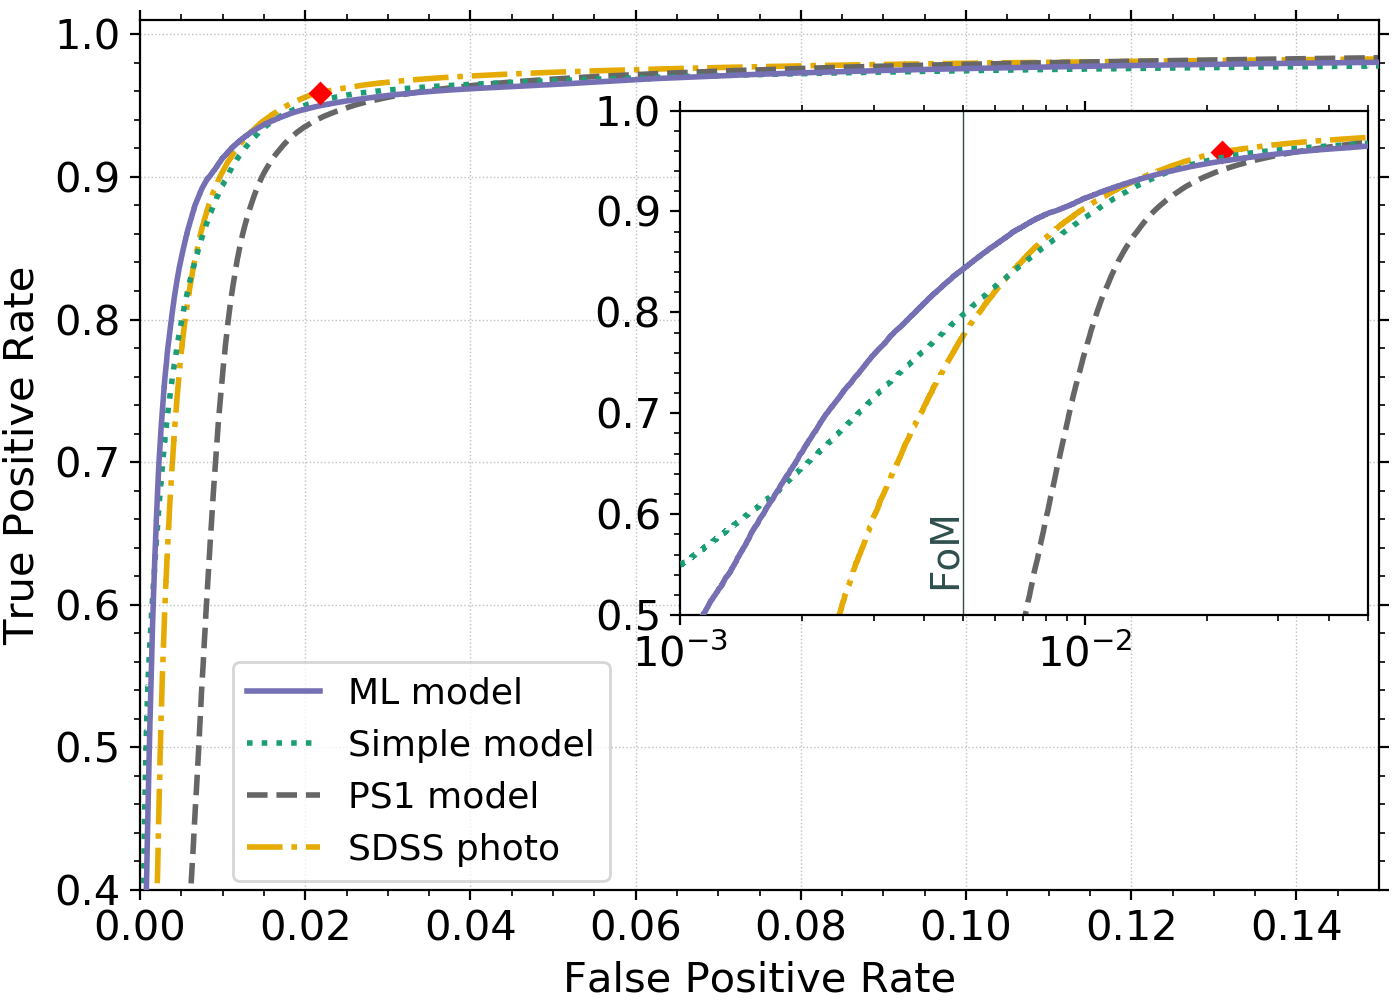

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cmap = plt.get_cmap("Dark2")

color_dict = {'ml': cmap(0.33), 
              'sdss': cmap(0.66), 
              'simple': cmap(0.),
              'ps1': cmap(1.)}

if(0):
    color_dict = {'ml': '#7570b3', 
                  'sdss': '#d95f02', 
                  'simple': '#1b9e77',
                  'ps1': '#34495e'}

col_star = 'red'

ls_dict = {'ml': '-', 
              'sdss': '-.', 
              'simple': ':',
              'ps1': '--'}

lw_dict = {'ml': 2., 
              'sdss': 2., 
              'simple': 2., 
              'ps1': 2.}

ylims = [0.4, 1.01]
xlims = [0, 1.5e-1]

fig, main_ax = plt.subplots(figsize=(7,5))
axins = inset_axes(main_ax, width="55.5%",  
                   height="58%", loc=3,
                   bbox_to_anchor=(0.425, 0.3, 1., 1.),
                   bbox_transform=main_ax.transAxes)

main_ax.grid(alpha=0.5, lw=0.5, c='grey', linestyle=':') 
main_ax.tick_params(which="both", top=True, right=True)
main_ax.minorticks_on()

main_ax.plot(ML_fpr, ML_tpr, color=color_dict['ml'], label='ML model', ls=ls_dict['ml'], lw=lw_dict['ml'], zorder=4)
main_ax.plot(dist_fpr, dist_tpr, color=color_dict['simple'], label='Simple model', ls=ls_dict['simple'], lw=lw_dict['simple'], zorder=3)
main_ax.plot(i_fpr, i_tpr, color=color_dict['ps1'], label='PS1 model', ls=ls_dict['ps1'], lw=lw_dict['ps1'], zorder=2)
main_ax.plot(sdss_fpr, sdss_tpr, color=color_dict['sdss'], label='SDSS photo', ls=ls_dict['sdss'], lw=lw_dict['sdss'], zorder=1)
main_ax.plot(sdss_fpr[np.argmin(np.abs(sdss_thre-10**(-0.185/2.5)))], 
        sdss_tpr[np.argmin(np.abs(sdss_thre-10**(-0.185/2.5)))], 'D', markersize=5, color=col_star, zorder=5)

main_ax.set_xlim(xlims); main_ax.set_ylim(ylims)
main_ax.tick_params(labelsize = 15)
main_ax.set_xlabel('False Positive Rate', fontsize=15)
main_ax.set_ylabel('True Positive Rate', fontsize=15)

main_ax.legend(loc=3, borderaxespad=0, fontsize=13,
               bbox_to_anchor=(0.075, 0.01, 1., 0.102), )

ylims = [0.5, 1.0]
xlims = np.array([1e-3, 5e-2])

origin = 'lower'
axins.tick_params(which="both", top=True)
axins.minorticks_on()

axins.plot(ML_fpr, ML_tpr, color=color_dict['ml'], label='ML model', ls=ls_dict['ml'], lw=lw_dict['ml'], zorder=4)
axins.plot(dist_fpr, dist_tpr, color=color_dict['simple'], label='Simple model', ls=ls_dict['simple'], lw=lw_dict['simple'], zorder=3)
axins.plot(i_fpr, i_tpr, color=color_dict['ps1'], label='PS1 model', ls=ls_dict['ps1'], lw=lw_dict['ps1'], zorder=2)
axins.plot(sdss_fpr, sdss_tpr, color=color_dict['sdss'], label='SDSS photo', ls=ls_dict['sdss'], lw=lw_dict['sdss'], zorder=1)
axins.plot(sdss_fpr[np.argmin(np.abs(sdss_thre-10**(-0.185/2.5)))], 
        sdss_tpr[np.argmin(np.abs(sdss_thre-10**(-0.185/2.5)))], 'D', markersize=5, color=col_star)


axins.vlines([5e-3], 1e-3, 1, 
          color='DarkSlateGrey', lw=.5)
axins.text(5e-3, 0.575, 'FoM', 
        color='DarkSlateGrey', 
        rotation=90, ha="right", fontsize=14)
axins.set_xlim(xlims); axins.set_ylim(ylims)
axins.set_xscale('log')
axins.tick_params(labelsize = 15)
fig.subplots_adjust(right=0.985,top=0.98,bottom=0.11,left=0.1)
fig.savefig('../paper/Figures/ROC_curves.pdf')

In [13]:
print(ML_tpr[np.argmin(np.abs(ML_fpr-0.005))])
print(dist_tpr[np.argmin(np.abs(dist_fpr-0.005))])
print(i_tpr[np.argmin(np.abs(i_fpr-0.005))])
print(sdss_tpr[np.argmin(np.abs(sdss_fpr-0.005))])

0.843086194224
0.797893197524
0.289760303357
0.777196527259


In [15]:
print(auc(ML_fpr, ML_tpr))
print(auc(dist_fpr, dist_tpr))
print(auc(i_fpr, i_tpr))
print(auc(sdss_fpr, sdss_tpr))

0.987131195553
0.985030198228
0.984117955705
0.986604756314


In [31]:
ml_decision_thresh = 0.5
sdss_decision_thresh = 10**(-0.185/2.5)
simple_decision_thresh = 9.2e-07 #  maximize acc on training set
ps1_decision_thresh = 0.05

ml_labels = np.logical_not(ML_predict[:,1] < ml_decision_thresh).astype(int)
sdss_labels = np.logical_not(np.array(sdss_tbl["countRatio"].ix[sdss_test_set]) < sdss_decision_thresh).astype(int)
simple_labels = np.logical_not(np.array(sdss_tbl["wwPSFKronDist"].ix[sdss_test_set]) < simple_decision_thresh).astype(int)
ps1_labels = np.logical_not(-1*np.array(sdss_tbl["iPSFminusKron"].ix[sdss_test_set]) < ps1_decision_thresh).astype(int)

In [32]:
binwidth = 0.5
Nboot = 100
mag_array = np.arange(13 , 23+binwidth, binwidth)
kron_mag = np.array(-2.5*np.log10(sdss_tbl['wwKronFlux'].ix[sdss_test_set]/3631))

sdss_acc_arr = np.zeros_like(mag_array)
simple_acc_arr = np.zeros_like(mag_array)
ps1_acc_arr = np.zeros_like(mag_array)
ml_acc_arr = np.zeros_like(mag_array)

sdss_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))


for bin_num, binedge in enumerate(mag_array):
    bin_sources = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth))
    sdss_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                           sdss_labels[bin_sources])
    simple_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                             simple_labels[bin_sources])
    ps1_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                          ps1_labels[bin_sources])
    ml_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                         ml_labels[bin_sources])
    sdss_boot_acc = np.empty(Nboot1
    simple_boot_acc = np.empty_like(sdss_boot_acc)
    ps1_boot_acc = np.empty_like(sdss_boot_acc)
    ml_boot_acc = np.empty_like(sdss_boot_acc)
    for i in range(Nboot):
        boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]), 
                                        replace=True)
        sdss_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                           sdss_labels[boot_sources])
        simple_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                             simple_labels[boot_sources])
        ps1_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                          ps1_labels[boot_sources])
        ml_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                         ml_labels[boot_sources])

    sdss_boot_scatt[:,bin_num] = np.percentile(sdss_boot_acc, [16, 84])
    simple_boot_scatt[:,bin_num] = np.percentile(simple_boot_acc, [16, 84])
    ps1_boot_scatt[:,bin_num] = np.percentile(ps1_boot_acc, [16, 84])
    ml_boot_scatt[:,bin_num] = np.percentile(ml_boot_acc, [16, 84])

/Users/y_tachibana/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [34]:
from sklearn.neighbors import KernelDensity
kde_grid = np.linspace(13,23.5,200)
sdss_stars = np.where(sdss_ml_test_y == 1)
sdss_gal = np.where(sdss_ml_test_y == 0)
sdss_kde_gal_norm = len(sdss_gal[0])/len(sdss_ml_test_y)
sdss_kde_star_norm = 1 - sdss_kde_gal_norm

kde_sdss = KernelDensity(bandwidth=1.059*np.std(kron_mag, ddof=1)*len(kron_mag)**(-0.2),
                         rtol=1E-4)
kde_sdss.fit(kron_mag[:, np.newaxis])

kde_sdss_stars = KernelDensity(bandwidth=1.059*np.std(kron_mag[sdss_stars], ddof=1)*len(kron_mag[sdss_stars])**(-0.2),
                               rtol=1E-4)
kde_sdss_stars.fit(kron_mag[sdss_stars[0], np.newaxis])

kde_sdss_gal = KernelDensity(bandwidth=1.059*np.std(kron_mag[sdss_gal], ddof=1)*len(kron_mag[sdss_gal])**(-0.2),
                             rtol=1E-4)
kde_sdss_gal.fit(kron_mag[sdss_gal[0], np.newaxis])

pdf_sdss = np.exp(kde_sdss.score_samples(kde_grid[:, np.newaxis]))
pdf_sdss_stars = np.exp(kde_sdss_stars.score_samples(kde_grid[:, np.newaxis]))
pdf_sdss_gal = np.exp(kde_sdss_gal.score_samples(kde_grid[:, np.newaxis]))

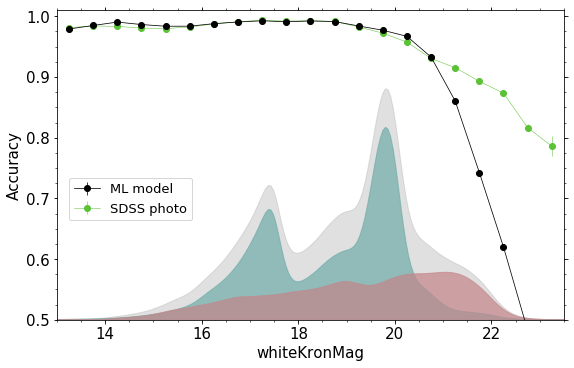

In [61]:
from matplotlib.ticker import MultipleLocator
color_dict = {'ml': "black", #"#1C1858",
              'sdss': "#5BC236", #"#00C78E",
              'simple': "#C864AF", #"#C70039",
              'ps1': "#C65400"}

mag_bin_centers = mag_array + binwidth/2
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(mag_bin_centers, ml_acc_arr, 
            yerr=np.abs(ml_boot_scatt - ml_acc_arr), 
            ls='-', lw=.75, fmt='o',
            color=color_dict['ml'], label="ML model", zorder=2)
"""
ax.errorbar(mag_bin_centers, simple_acc_arr, 
            yerr=np.abs(simple_boot_scatt - simple_acc_arr), 
            ls ='-', lw=.5, fmt='o',
            color=color_dict['simple'], label="Simple model")
ax.errorbar(mag_bin_centers, ps1_acc_arr, 
            yerr=np.abs(ps1_boot_scatt - ps1_acc_arr), 
            ls ='-', lw=.5, dashes=(8, 4), fmt='o',
            color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
"""
ax.errorbar(mag_bin_centers, sdss_acc_arr, 
            yerr=np.abs(sdss_boot_scatt - sdss_acc_arr), 
            ls='-', lw=.5, fmt='o',
            color=color_dict['sdss'], label="SDSS photo", zorder=1)

# add KDE plots
ax.fill(kde_grid, pdf_sdss + 0.5, alpha=0.4, color="0.7")
ax.fill(kde_grid, pdf_sdss_gal*sdss_kde_gal_norm + 0.5, alpha=0.7, color=cmap_gal(0.25))
ax.fill(kde_grid, pdf_sdss_stars*sdss_kde_star_norm + 0.5, alpha=0.7, color=cmap_star(0.25))

ax.set_ylim(0.5,1.01)
ax.set_xlim(13, 23.5)
ax.tick_params(which="both", top=True, right=True, labelsize=15)
ax.set_xlabel('whiteKronMag', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)

ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

ax.legend(bbox_to_anchor=(0.01, 0.3, 1., 0.102), loc=3, fontsize=13)

fig.subplots_adjust(top=0.98,right=0.98,left=0.1,bottom=0.12)

In [55]:
binwidth = 0.5
Nboot = 100

# bootstrap star arrays
sdss_star_acc_arr = np.zeros_like(mag_array)
simple_star_acc_arr = np.zeros_like(mag_array)
ps1_star_acc_arr = np.zeros_like(mag_array)
ml_star_acc_arr = np.zeros_like(mag_array)

sdss_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

# bootstrap galaxy arrays
sdss_gal_acc_arr = np.zeros_like(mag_array)
simple_gal_acc_arr = np.zeros_like(mag_array)
ps1_gal_acc_arr = np.zeros_like(mag_array)
ml_gal_acc_arr = np.zeros_like(mag_array)

sdss_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

for bin_num, binedge in enumerate(mag_array):
    bin_stars = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                         (sdss_ml_test_y == 1))
    sdss_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                           sdss_labels[bin_stars])
    simple_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                             simple_labels[bin_stars])
    ps1_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                          ps1_labels[bin_stars])
    ml_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                         ml_labels[bin_stars])
    
    bin_gals = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                        (sdss_ml_test_y == 0))
    sdss_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                           sdss_labels[bin_gals])
    simple_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                             simple_labels[bin_gals])
    ps1_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                          ps1_labels[bin_gals])
    ml_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                         ml_labels[bin_gals])    
    
    # get the bootstrap accuracies
    
    sdss_star_boot_acc = np.empty(Nboot)
    simple_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ps1_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ml_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    
    sdss_gal_boot_acc = np.empty_like(sdss_star_boot_acc)
    simple_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ps1_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ml_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)

    for i in range(Nboot):
        star_boot_sources = np.random.choice(bin_stars[0], len(bin_stars[0]), 
                                             replace=True)
        sdss_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                           sdss_labels[star_boot_sources])
        simple_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                             simple_labels[star_boot_sources])
        ps1_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                          ps1_labels[star_boot_sources])
        ml_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                         ml_labels[star_boot_sources])
        
        gal_boot_sources = np.random.choice(bin_gals[0], len(bin_gals[0]), 
                                            replace=True)
        sdss_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                           sdss_labels[gal_boot_sources])
        simple_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                             simple_labels[gal_boot_sources])
        ps1_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                          ps1_labels[gal_boot_sources])
        ml_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                         ml_labels[gal_boot_sources])


    sdss_star_boot_scatt[:,bin_num] = np.percentile(sdss_star_boot_acc, [16, 84])
    simple_star_boot_scatt[:,bin_num] = np.percentile(simple_star_boot_acc, [16, 84])
    ps1_star_boot_scatt[:,bin_num] = np.percentile(ps1_star_boot_acc, [16, 84])
    ml_star_boot_scatt[:,bin_num] = np.percentile(ml_star_boot_acc, [16, 84])    
    
    sdss_gal_boot_scatt[:,bin_num] = np.percentile(sdss_gal_boot_acc, [16, 84])
    simple_gal_boot_scatt[:,bin_num] = np.percentile(simple_gal_boot_acc, [16, 84])
    ps1_gal_boot_scatt[:,bin_num] = np.percentile(ps1_gal_boot_acc, [16, 84])
    ml_gal_boot_scatt[:,bin_num] = np.percentile(ml_gal_boot_acc, [16, 84])

In [84]:
binwidth = 0.5
Nboot = 100

sdss_resamp_arr = np.zeros_like(mag_array)
simple_resamp_arr = np.zeros_like(mag_array)
ps1_resamp_arr = np.zeros_like(mag_array)
ml_resamp_arr = np.zeros_like(mag_array)

sdss_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

# bootstrap star arrays
sdss_star_resamp_arr = np.zeros_like(mag_array)
simple_star_resamp_arr = np.zeros_like(mag_array)
ps1_star_resamp_arr = np.zeros_like(mag_array)
ml_star_resamp_arr = np.zeros_like(mag_array)

sdss_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

# bootstrap galaxy arrays
sdss_gal_resamp_arr = np.zeros_like(mag_array)
simple_gal_resamp_arr = np.zeros_like(mag_array)
ps1_gal_resamp_arr = np.zeros_like(mag_array)
ml_gal_resamp_arr = np.zeros_like(mag_array)

sdss_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

for bin_num, binedge in enumerate(mag_array):
    if bin_num <= 3:
        continue
    
    bin_stars = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                         (sdss_ml_test_y == 1))
    
    bin_gals = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                        (sdss_ml_test_y == 0))

    hst_stars = np.where((hst_kron_mag >= binedge) & (hst_kron_mag < binedge + binwidth) & 
                         (hst_ml_train_y == 1))
    hst_gals = np.where((hst_kron_mag >= binedge) & (hst_kron_mag < binedge + binwidth) & 
                        (hst_ml_train_y == 0))
    
    # figure out the number of stars and galaxies to select
    if len(hst_stars[0])/len(hst_gals[0]) > len(bin_stars[0])/len(bin_gals[0]):
        n_star_resamp = len(bin_stars[0])
        n_gal_resamp = int(len(bin_stars[0])*len(hst_gals[0])/len(hst_stars[0]))
    else:
        n_star_resamp = int(len(bin_gals[0])*len(hst_stars[0])/len(hst_gals[0]))
        n_gal_resamp = len(bin_gals[0])
    
    print(len(hst_stars[0]), len(hst_gals[0]), 
          len(bin_stars[0]), len(bin_gals[0]),
          n_star_resamp, n_gal_resamp)
    
    # get the bootstrap accuracies    
    sdss_boot_acc = np.empty(Nboot)
    simple_boot_acc = np.empty_like(sdss_boot_acc)
    ps1_boot_acc = np.empty_like(sdss_boot_acc)
    ml_boot_acc = np.empty_like(sdss_boot_acc)

    sdss_star_boot_acc = np.empty(Nboot)
    simple_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ps1_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ml_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    
    sdss_gal_boot_acc = np.empty_like(sdss_star_boot_acc)
    simple_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ps1_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ml_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)

    for i in range(Nboot):
        star_boot_sources = np.random.choice(bin_stars[0], n_star_resamp, 
                                             replace=True)
        gal_boot_sources = np.random.choice(bin_gals[0], n_gal_resamp, 
                                            replace=True)
        boot_sources = np.append(star_boot_sources, gal_boot_sources)

        sdss_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                           sdss_labels[boot_sources])
        simple_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                             simple_labels[boot_sources])
        ps1_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                          ps1_labels[boot_sources])
        ml_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                         ml_labels[boot_sources])

        sdss_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                           sdss_labels[star_boot_sources])
        simple_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                             simple_labels[star_boot_sources])
        ps1_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                          ps1_labels[star_boot_sources])
        ml_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                         ml_labels[star_boot_sources])
        
        sdss_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                           sdss_labels[gal_boot_sources])
        simple_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                             simple_labels[gal_boot_sources])
        ps1_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                          ps1_labels[gal_boot_sources])
        ml_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                         ml_labels[gal_boot_sources])


    sdss_resamp_arr[bin_num] = np.mean(sdss_boot_acc)
    simple_resamp_arr[bin_num] = np.mean(simple_boot_acc)
    ps1_resamp_arr[bin_num] = np.mean(ps1_boot_acc)
    ml_resamp_arr[bin_num] = np.mean(ml_boot_acc)
    
    sdss_resamp_scatt[:,bin_num] = np.percentile(sdss_boot_acc, [16, 84])
    simple_resamp_scatt[:,bin_num] = np.percentile(simple_boot_acc, [16, 84])
    ps1_resamp_scatt[:,bin_num] = np.percentile(ps1_boot_acc, [16, 84])
    ml_resamp_scatt[:,bin_num] = np.percentile(ml_boot_acc, [16, 84])    

    sdss_star_resamp_arr[bin_num] = np.mean(sdss_star_boot_acc)
    simple_star_resamp_arr[bin_num] = np.mean(simple_star_boot_acc)
    ps1_star_resamp_arr[bin_num] = np.mean(ps1_star_boot_acc)
    ml_star_resamp_arr[bin_num] = np.mean(ml_star_boot_acc)
    
    sdss_star_resamp_scatt[:,bin_num] = np.percentile(sdss_star_boot_acc, [16, 84])
    simple_star_resamp_scatt[:,bin_num] = np.percentile(simple_star_boot_acc, [16, 84])
    ps1_star_resamp_scatt[:,bin_num] = np.percentile(ps1_star_boot_acc, [16, 84])
    ml_star_resamp_scatt[:,bin_num] = np.percentile(ml_star_boot_acc, [16, 84])    

    sdss_gal_resamp_arr[bin_num] = np.mean(sdss_gal_boot_acc)
    simple_gal_resamp_arr[bin_num] = np.mean(simple_gal_boot_acc)
    ps1_gal_resamp_arr[bin_num] = np.mean(ps1_gal_boot_acc)
    ml_gal_resamp_arr[bin_num] = np.mean(ml_gal_boot_acc)
    
    sdss_gal_resamp_scatt[:,bin_num] = np.percentile(sdss_gal_boot_acc, [16, 84])
    simple_gal_resamp_scatt[:,bin_num] = np.percentile(simple_gal_boot_acc, [16, 84])
    ps1_gal_resamp_scatt[:,bin_num] = np.percentile(ps1_gal_boot_acc, [16, 84])
    ml_gal_resamp_scatt[:,bin_num] = np.percentile(ml_gal_boot_acc, [16, 84])

126 3 23645 22763 23645 562
161 6 36897 45170 36897 1375
206 10 50611 94001 50611 2456
288 29 66261 166928 66261 6672
325 57 70723 293069 70723 12403
401 93 79154 174356 79154 18357
472 176 89247 131564 89247 33278
633 343 107231 188220 107231 58104
731 653 106618 255031 106618 95241
926 1057 111399 528090 111399 127158
1007 1756 133584 237271 133584 232942
1200 2811 137765 76111 32491 76111
1397 4375 137181 30476 9731 30476
1416 6133 97725 19126 4415 19126
1120 6738 31678 7312 1215 7312
765 5704 4325 1319 176 1319
370 3312 478 125 13 125


In [76]:
kde_grid = np.linspace(13,23.5,200)
hst_stars = np.where(hst_ml_train_y == 1)
hst_gal = np.where(hst_ml_train_y == 0)

kde_hst = KernelDensity(bandwidth=1.059*np.std(hst_kron_mag, ddof=1)*len(hst_kron_mag)**(-0.2),
                         rtol=1E-4)
kde_hst.fit(hst_kron_mag[:, np.newaxis])

kde_hst_stars = KernelDensity(bandwidth=1.059*np.std(hst_kron_mag[hst_stars], ddof=1)*len(hst_kron_mag[hst_stars])**(-0.2),
                               rtol=1E-4)
kde_hst_stars.fit(hst_kron_mag[hst_stars[0], np.newaxis])

kde_hst_gal = KernelDensity(bandwidth=1.059*np.std(hst_kron_mag[hst_gal], ddof=1)*len(hst_kron_mag[hst_gal])**(-0.2),
                             rtol=1E-4)
kde_hst_gal.fit(hst_kron_mag[hst_gal[0], np.newaxis])

pdf_hst = np.exp(kde_hst.score_samples(kde_grid[:, np.newaxis]))
pdf_hst_stars = np.exp(kde_hst_stars.score_samples(kde_grid[:, np.newaxis]))
pdf_hst_gal = np.exp(kde_hst_gal.score_samples(kde_grid[:, np.newaxis]))

hst_kde_gal_norm = len(hst_gal[0])/len(hst_ml_train_y)
hst_kde_star_norm = 1 - hst_kde_gal_norm

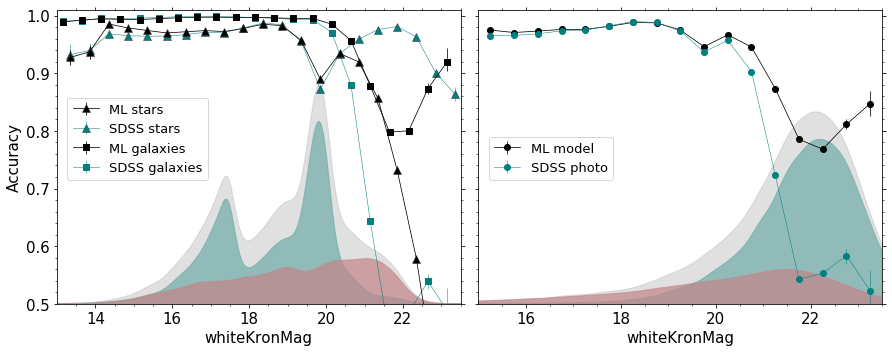

In [111]:
color_dict = {'ml': "black", #"#1C1858",
              'sdss': "teal",
              'simple': "#C864AF", #"#C70039",
              'ps1': "#C65400"}

plt.figure(figsize=(12.5,5))

plt.subplot(1,2,1)

plt.errorbar(mag_bin_centers+0.1, ml_star_acc_arr, 
            yerr=np.abs(ml_star_boot_scatt - ml_star_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt='^', ms=8,
            mec="0.2", mew=0.5,
            color=color_dict['ml'], label="ML stars", zorder=4)
# ax.errorbar(mag_bin_centers, simple_star_acc_arr, 
#             yerr=np.abs(simple_star_boot_scatt - simple_star_acc_arr), 
#             ls =ls_dict['simple'], lw=.5, fmt='*', ms=10,
#             mec="0.2", mew=0.5,
#             color=color_dict['simple'], label="Simple model")
# ax.errorbar(mag_bin_centers, ps1_star_acc_arr, 
#             yerr=np.abs(ps1_star_boot_scatt - ps1_star_acc_arr), 
#             ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt='*', ms=10,
#             mec="0.2", mew=0.5,
#             color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
plt.errorbar(mag_bin_centers+0.1, sdss_star_acc_arr, 
            yerr=np.abs(sdss_star_boot_scatt - sdss_star_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt='^', ms=8,
            mec="0.2", mew=0.5,
            color=color_dict['sdss'], label="SDSS stars", zorder=2)


plt.errorbar(mag_bin_centers-0.1, ml_gal_acc_arr, 
            yerr=np.abs(ml_gal_boot_scatt - ml_gal_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt='s',
            color=color_dict['ml'], label="ML galaxies", zorder=3)
# ax.errorbar(mag_bin_centers, simple_gal_acc_arr, 
#             yerr=np.abs(simple_gal_boot_scatt - simple_gal_acc_arr), 
#             ls =ls_dict['simple'], lw=.5, fmt=',',
#             color=color_dict['simple'], label="Simple model")
# ax.errorbar(mag_bin_centers, ps1_gal_acc_arr, 
#             yerr=np.abs(ps1_gal_boot_scatt - ps1_gal_acc_arr), 
#             ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt=',',
#             color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
plt.errorbar(mag_bin_centers-0.1, sdss_gal_acc_arr, 
            yerr=np.abs(sdss_gal_boot_scatt - sdss_gal_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt='s',
            color=color_dict['sdss'], label="SDSS galaxies", zorder=1)

# add KDE plots
plt.fill(kde_grid, pdf_sdss + 0.5, alpha=0.4, color="0.7")
plt.fill(kde_grid, pdf_sdss_gal*sdss_kde_gal_norm + 0.5, alpha=0.7, color=cmap_gal(0.25))
plt.fill(kde_grid, pdf_sdss_stars*sdss_kde_star_norm + 0.5, alpha=0.7, color=cmap_star(0.25))

plt.ylim(0.5,1.01)
plt.xlim(13, 23.5)
plt.tick_params(which="both", top=True, right=True, labelsize=15)
plt.xlabel('whiteKronMag', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.minorticks_on()

#plt.yaxis.set_minor_locator(MultipleLocator(0.025))
#plt.xaxis.set_major_locator(MultipleLocator(2))
#plt.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.legend(bbox_to_anchor=(0.01, 0.4, 1., 0.102), loc=3, fontsize=13)

plt.subplot(1,2,2)

plt.errorbar(mag_bin_centers[4:], ml_resamp_arr[4:], 
            yerr=np.abs(ml_resamp_scatt - ml_resamp_arr)[:,4:], 
            ls =ls_dict['ml'], lw=.75, fmt='o',
            color=color_dict['ml'], label="ML model")
"""
ax.errorbar(mag_bin_centers[4:], simple_resamp_arr[4:], 
            yerr=np.abs(simple_resamp_scatt - simple_resamp_arr)[:,4:], 
            ls =ls_dict['simple'], lw=.5, fmt='o',
            color=color_dict['simple'], label="Simple model")
ax.errorbar(mag_bin_centers[4:], ps1_resamp_arr[4:], 
            yerr=np.abs(ps1_resamp_scatt - ps1_resamp_arr)[:,4:], 
            ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt='o',
            color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
"""
plt.errorbar(mag_bin_centers[4:], sdss_resamp_arr[4:], 
            yerr=np.abs(sdss_resamp_scatt - sdss_resamp_arr)[:,4:], 
            ls=ls_dict['sdss'], lw=.5, fmt='o',
            color=color_dict['sdss'], label="SDSS photo")

# add KDE plots
plt.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst, 0) + 0.5, alpha=0.4, color="0.7")
plt.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst_gal*hst_kde_gal_norm, 0) + 0.5, alpha=0.7, color=cmap_gal(0.25))
plt.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst_stars*hst_kde_star_norm, 0) + 0.5, alpha=0.7, color=cmap_star(0.25))

plt.ylim(0.5,1.01)
plt.xlim(15, 23.5)
plt.tick_params(which="both", top=True, right=True, labelsize=15, labelleft='off')
plt.xlabel('whiteKronMag', fontsize=15)
#plt.ylabel('Accuracy', fontsize=15)
plt.minorticks_on()

plt.legend(bbox_to_anchor=(0.01, 0.4, 1., 0.102), loc=3, fontsize=13)

plt.tight_layout()

plt.savefig('Accuracy_SDSS_ML_model.pdf')